In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import pandas as pd
import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import arrow
import gsw
import time

In [3]:
new_JS_bc = nc.Dataset('./preind_DIC/JS_diseq_preind_DIC_allup.nc')
new_JS_bc_DIC = (new_JS_bc['preindustrial_DIC']['preind_dic'])
old_JS_bc = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA_preind_091719.nc')
old_JS_bc_DIC = old_JS_bc['DIC']
presday_JS_bc = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA.nc')
presday_JS_bc_DIC = presday_JS_bc['DIC']

print(np.shape(old_JS_bc_DIC))
print(np.shape(new_JS_bc_DIC))

# fact = 0.8
# fig, axs = plt.subplots(2,6, figsize=(4*fact, 6*fact), facecolor='w', edgecolor='k')


(12, 40, 10, 30)
(12, 40, 10, 30)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


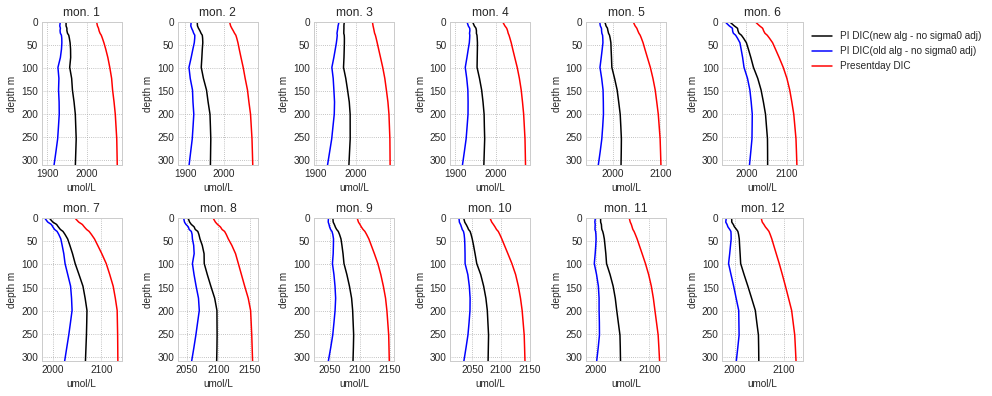

In [4]:
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depths = w['gdept_1d'][0,:]

fact = 0.4
fig, axs = plt.subplots(2,6, figsize=(34.7*fact, 14*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)

ty = 15
tx = 5
axs = axs.ravel()
for i in range(0,12):
    
    axs[i].plot( (np.nanmean(np.nanmean(new_JS_bc_DIC[i,:,:,:],axis = 1,),axis = 1)),\
                depths, color = 'k', \
                linestyle = '-', label = 'PI DIC(new alg - no sigma0 adj)')
    axs[i].plot( (np.nanmean(np.nanmean(old_JS_bc_DIC[i,:,:,:],axis = 1,),axis = 1)),\
            depths, color = 'b', \
            linestyle = '-', label = 'PI DIC(old alg - no sigma0 adj)')

    axs[i].plot( (np.nanmean(np.nanmean(presday_JS_bc_DIC[i,:,:,:],axis = 1,),axis = 1)),\
                depths, color = 'r', \
                linestyle = '-', label = 'Presentday DIC')
    axs[5].legend(bbox_to_anchor = [1,1])
    axs[i].grid();
    
for i in range(0,12):
    
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    axs[i].set_title(f'mon. {i+1}')
    axs[i].set_ylabel('depth m')
    axs[i].set_xlabel('umol/L')
    axs[i].grid(b=True, which='major', color='darkgrey', linestyle=':')
plt.tight_layout()

In [ ]:
presday_JS_bc = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA.nc')
presday_JS_bc_OXY = presday_JS_bc['OXY']

In [19]:
def co2_from_year(year):
    
    import pandas as pd
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #('year > 2018, using value for 2018')       
    if whole_year <= 1832:
        whole_year = 1832
        #('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2

def toy_preind_DIC_calculator(DIC, TA, O2, depth,sal, temp):
    
    
    import gsw
    import numpy as np
    
    # TJSJ calculate sigma0 
    sigma0 = gsw.sigma0(sal,temp)
    
    
    ## TJSJ find pycnal witnessed co2 (age from relationship with sigma0)
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104 #change to 2015 since model year is 2015

    pycnal_last_at_surface = \
    2015 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_witnessed_atm_co2 = co2_from_year(pycnal_last_at_surface)
    
    # TJSJ calculate AOU, for which we need o2 solubility in umol/L
    osol = gsw.O2sol(sal,temp,0,-125,50)
    #convert osol to umol/L
    osol_umolL = osol*(1000/(1000+sigma0))
    AOU = osol_umolL - O2
    
    # TJSJ get stoichiometric AOU using (117/170)
    AOU_stoich = AOU * (117/170)
    
    # TJSJ calculate preformed DIC
    preformed_DIC = DIC - AOU_stoich

    return sigma0, pycnal_last_at_surface, AOU

In [21]:
DIC = 2050; TA = 2200; OXY = 200; depth = 0; sal = 34;  temp = 7

sigma0, pycnal_last_at_surface, AOU = \
toy_preind_DIC_calculator(DIC, TA, OXY, depth,sal, temp)

print(f'sigma0: {sigma0}')
print(f'pycnal last at surface: {pycnal_last_at_surface}')
print(f'AOU: {AOU}')

sigma0: 26.507752150228725
pycnal last at surface: 1982.412263588211
AOU: 88.36319644392893
